<a href="https://colab.research.google.com/github/Jasmine97Huang/content_analysis_hw/blob/main/SOCI40133_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/transformers
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, AutoTokenizer
from transformers import AdamW, BertForSequenceClassification, BertForMaskedLM
from tqdm import tqdm, trange
import spacy
import pandas as pd
from ast import literal_eval
import io
import numpy as np
import matplotlib.pyplot as plt
#!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
#import lucem_illud
import embeddings
import sklearn


In [ ]:
%matplotlib inline

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, MaxPool1D
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Preparation

Issue with the dataset: each data sources contain different columns. The lyric formats are not exactly the same for billboard, spotify and metro lyrics.

In [ ]:
data = pd.read_csv("sp_bb_metro_matched.csv")

In [ ]:
data

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched
0,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",2017,28.0,False,False,False,False,False,True,Unknown,2010s,steady rollin,group
1,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",2005,0.0,False,False,False,True,False,False,Unknown,2000s,bell biv devoe,group
2,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,2012,41.0,False,False,False,True,False,False,Unknown,2010s,ceelo green,male
3,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,2019,65.0,False,False,True,False,False,False,Unknown,2010s,kard,unknown
4,Soldier,James TW,"Hold your breath, don't look down, keep trying...",2019,70.0,False,False,False,True,False,False,Unknown,2010s,james tw,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236080,Who Am I Drinking Tonight,Edens Edge,I gotta say Boy after only just a couple of da...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge,unknown
236081,Liar,Edens Edge,I helped you find her diamond ring You made me...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge,unknown
236082,Last Supper,Edens Edge,Look at the couple in the corner booth Looks a...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge,unknown
236083,Christ Alone Live In Studio,Edens Edge,When I fly off this mortal earth And I'm measu...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge,unknown


In [ ]:
data.year_bin.value_counts()

2000s    153608
2010s     67727
1990s      8443
1980s      3337
1970s      2970
Name: year_bin, dtype: int64

In [ ]:
data.gender_matched.value_counts() #not balanced

unknown                  111201
group                     87401
male                      28900
female                     8091
non-binary                  317
androgynous                  76
agender                      36
genderfluid                  32
genderqueer                  12
transgender woman            12
transgender                   6
gender non-conforming         1
Name: gender_matched, dtype: int64

In [ ]:
def convert_gender(g):
    if g not in ['male', 'female', 'group']:
        return 'Non-binary'
    else:
        return g
def gender_encoder(g):
    if g not in ['male', 'female']:
        return 2 #non-binary
    elif g == 'female':
        return 1
    else:
        return 0 #male


In [ ]:
df = data[~data.gender_matched.isin(["Unknown", "group","unknown"])].reset_index(drop = True)
df['gender_matched'] = df.gender_matched.apply(lambda x: gender_encoder(x))

In [ ]:
df.gender_matched.value_counts()

0    28900
1     8091
2      492
Name: gender_matched, dtype: int64

#### Sentence Segmentation

In [ ]:
df.lyrics

2         I really can't stay Baby it's cold outside I'v...
4         Hold your breath, don't look down, keep trying...
5         All I want is somebody who's gonna love me for...
9         I see no changes, wake up in the morning and I...
10        Hey, it's a sellout! Hey! Let me welcome you, ...
                                ...                        
235756    Lay some happiness on me So the brighter side ...
235757    Baby O You I dig Like a the most Ooh really bi...
235758    Blue moon you saw me standing alone Without a ...
235759    People used to call me nobody's baby Up until ...
235760    Lullaby and good night with pink roses bed lig...
Name: lyrics, Length: 37483, dtype: object

In [ ]:
sum([len(s) for s in sentences])/len(sentences)

1612.4418803190779

In [ ]:
len(df)

37483

In [ ]:
len(sentences)

37483

In [ ]:
df['segmented'] = None
nlp = spacy.load('en')

lyrics = df.lyrics.values.tolist()
for i, para in enumerate(lyrics):
    tokens = nlp(para)
    lst = []
    for sent in tokens.sents:
        lst.append(sent.string.strip())
    #print(lst)
    df.at[i, 'segmented'] = lst

In [ ]:
df['song_index'] = df.index.tolist()

In [ ]:
df.to_csv("mlm_lyrics.csv")

## Tokenize

In [ ]:
df = pd.read_csv("mlm_lyrics.csv", index_col = 0)

In [ ]:
segmented = [literal_eval(x) for x in df.segmented.to_list()]

In [ ]:
df['segmented'] = segmented

In [ ]:
df = df.explode('segmented')
df

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index
0,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,2012,41.0,False,False,False,True,False,False,Unknown,2010s,ceelo green,0,I really can't stay Baby,0
0,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,2012,41.0,False,False,False,True,False,False,Unknown,2010s,ceelo green,0,it's cold outside,0
0,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,2012,41.0,False,False,False,True,False,False,Unknown,2010s,ceelo green,0,I've got to go away,0
0,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,2012,41.0,False,False,False,True,False,False,Unknown,2010s,ceelo green,0,Baby,0
0,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,2012,41.0,False,False,False,True,False,False,Unknown,2010s,ceelo green,0,it's cold out there,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37482,Brahm S Lullaby,Dean Martin,Lullaby and good night with pink roses bed lig...,2014,NaN,False,False,False,False,False,False,Unknown,2010s,dean martin,0,Lullaby and good night with pink roses bed lig...,37482
37482,Brahm S Lullaby,Dean Martin,Lullaby and good night with pink roses bed lig...,2014,NaN,False,False,False,False,False,False,Unknown,2010s,dean martin,0,is your bed close your eyes and rest your head...,37482
37482,Brahm S Lullaby,Dean Martin,Lullaby and good night with pink roses bed lig...,2014,NaN,False,False,False,False,False,False,Unknown,2010s,dean martin,0,mother's right here beside you I'll protect yo...,37482
37482,Brahm S Lullaby,Dean Martin,Lullaby and good night with pink roses bed lig...,2014,NaN,False,False,False,False,False,False,Unknown,2010s,dean martin,0,you will wake in my arms,37482


In [ ]:
# Create sentence and label lists
sentences = df.segmented.values.tolist()

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
#labels = df.gender_matched.values

In [ ]:
MAX_LEN = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
df['tokenized_text'] = tokenized_texts
sentences = df.tokenized_text.to_list()
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in sentences]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
df.to_csv("mlm_tokenized.csv")

In [ ]:
sentences[10]

['[CLS]', ',', 'please', 'don', "'", 't', 'hurry', '[SEP]']

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mlm_tokenized.csv", index_col = 0)
tokenized_text = [literal_eval(x) for x in df.tokenized_text.to_list()]
df['tokenized_text'] = tokenized_text

In [ ]:
df = df.reset_index(drop = True)

#BERT MLM

## Set up Input & Masks

### Create True Label for MLM

In [ ]:
labels = input_ids.copy()

### Use bad-words.txt to generate masked tokens 
Mask words that are "bad" words + randomly masking 15% of the tokens

In [ ]:
with open('bad-words.txt', 'r') as fp:
    bad_wrds = fp.read().split('\n')

In [ ]:
bad_wrds_ids= [tokenizer.convert_tokens_to_ids(x) for x in bad_wrds]

In [ ]:
bad_wrds_ids = set(bad_wrds_ids)

In [ ]:
len(bad_wrds_ids)

312

In [ ]:
mask_arr = np.asarray([wrd in bad_wrds_ids for sent in input_ids for wrd in sent]).reshape(input_ids.shape)
mask_arr

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
sum([wrd in bad_wrds_ids for sent in input_ids for wrd in sent])/sum([len(sent) for sent in sentences]) #percentage of tokens that are bad words and masked. 0.01351043435727458

0.01351043435727458

In [ ]:
rand = np.random.rand(input_ids.shape[0], input_ids.shape[1])

In [ ]:
sep_tokens = np.asarray([wrd not in [101, 102, 0] for sent in input_ids for wrd in sent]).reshape(input_ids.shape) #do not mask [CLS], [SEP]

In [ ]:
mask_arr = np.logical_or(mask_arr, np.logical_and((rand < 0.15), sep_tokens))

In [ ]:
np.sum(mask_arr) #number of masked tokens 2482339

2480896

In [ ]:
np.sum(mask_arr)/sum([len(sent) for sent in sentences])  #perc of masked token/total tokens 0.13467135995375143

0.13459307460577385

In [ ]:
mask_arr.shape

(1647695, 128)

In [ ]:
selection = []

for i in range(mask_arr.shape[0]):
    selection.append(np.flatnonzero(mask_arr[i]).tolist())

selection[0]

[6]

In [ ]:
for i in range(mask_arr.shape[0]): #set mask token id to input_ids
    input_ids[i, selection[i]] = 103

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [i == 103 for i in seq]
    attention_masks.append(seq_mask)

#attention_masks= np.array(attention_masks. dtype = "int")
attention_masks= np.array(attention_masks, dtype = "int")
attention_masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
np.sum(attention_masks) #2482339

2482541

In [ ]:
#inputs = {'input_ids': input_ids, 'labels': labels, 'attention_mask': attention_masks}

In [ ]:
1647695*0.5

823847.5

In [ ]:
inputs_mini = {'input_ids': torch.from_numpy(input_ids[:823847]), 'labels': torch.from_numpy(labels[:823847]), 'attention_mask': torch.from_numpy(attention_masks[:823847])}

In [ ]:
inputs = {'input_ids': input_ids, 'labels': labels, 'attention_mask': attention_masks}
with open('inputs.npy', 'wb') as f:
    np.save(f, input_ids)
    np.save(f, labels)
    np.save(f, attention_masks)

In [ ]:
input_ids[mask_arr]

array([103, 103, 103, ..., 103, 103, 103])

In [ ]:
with open('inputs_mini.npy', 'wb') as f:
    np.save(f, input_ids[:100])
    np.save(f, labels[:100])
    np.save(f, attention_masks[:100])

## Dataloader Class

In [ ]:
class LyricsMLMDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
dataset = LyricsMLMDataset(inputs_mini)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

## Model

In [ ]:
model = BertForMaskedLM.from_pretrained("bert-base-uncased")
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
model.train()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
optim = AdamW(model.parameters(), lr=1e-7)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## Training

In [ ]:
epochs = 1

for epoch in range(epochs):
    loop = tqdm(dataloader, leave = True)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss=outputs.loss
        loss.backward()
        optim.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/25746 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Epoch 0: 100%|██████████| 25746/25746 [3:21:09<00:00,  2.13it/s, loss=0.102]


In [ ]:
#torch.save(model, 'path/to/model')
model.save_pretrained('mlm_bert')

#Evaluation

## mlm_bert_mini

In [ ]:
model = BertForMaskedLM.from_pretrained("/content/drive/MyDrive/mlm_bert_mini")

In [ ]:
text = "That's my best friend, she a real bad" + tokenizer.mask_token
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

That's my best friend, she a real bad.
That's my best friend, she a real bad!
That's my best friend, she a real bad;
That's my best friend, she a real bad?
That's my best friend, she a real bad...
That's my best friend, she a real bad##ass
That's my best friend, she a real badcause
That's my best friend, she a real badthing
That's my best friend, she a real bad,
That's my best friend, she a real badass


### b_df - masks for lyrics that uses "bitch"

In [ ]:
df = df.reset_index(drop = True)

b_df = df.tokenized_text.apply(lambda x: "bitch" in x)

In [ ]:
df.iloc[8531].segmented

"All these bitches' flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"

In [ ]:
text = "All these " + tokenizer.mask_token + " flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

All these cash flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these money flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these blood flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these shit flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these life flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these energy flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these time flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these air flows is my mini-me Body smoking, so they call me Y

In [ ]:
print(df.iloc[1568163].segmented)

And I don't wanna hear it stop being a bitch You making me respect you less


In [ ]:
text = "And I don't wanna hear it stop being a " + tokenizer.mask_token + " You making me respect you less"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

And I don't wanna hear it stop being a joke You making me respect you less
And I don't wanna hear it stop being a song You making me respect you less
And I don't wanna hear it stop being a bitch You making me respect you less
And I don't wanna hear it stop being a reason You making me respect you less
And I don't wanna hear it stop being a fight You making me respect you less
And I don't wanna hear it stop being a mess You making me respect you less
And I don't wanna hear it stop being a fuck You making me respect you less
And I don't wanna hear it stop being a habit You making me respect you less
And I don't wanna hear it stop being a noise You making me respect you less
And I don't wanna hear it stop being a problem You making me respect you less


##mlm_bert_base

In [ ]:
!unzip /content/mlm_bert_base.zip -d /content/

Archive:  /content/mlm_bert_base.zip
   creating: /content/mlm_bert_base/
  inflating: /content/__MACOSX/._mlm_bert_base  
  inflating: /content/mlm_bert_base/config.json  
  inflating: /content/mlm_bert_base/pytorch_model.bin  


In [ ]:
model = BertForMaskedLM.from_pretrained("/content/mlm_bert_base")

In [ ]:
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
text = "That's my best friend, she a real bad" + tokenizer.mask_token
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

That's my best friend, she a real bad.
That's my best friend, she a real bad!
That's my best friend, she a real bad;
That's my best friend, she a real bad?
That's my best friend, she a real bad...
That's my best friend, she a real bad##ass
That's my best friend, she a real badcause
That's my best friend, she a real badthing
That's my best friend, she a real bad,
That's my best friend, she a real badass


### b_df - masks for lyrics that uses "bitch"

In [ ]:
df = df.reset_index(drop = True)

b_df = df.tokenized_text.apply(lambda x: "bitch" in x)

In [ ]:
set(df[b_df & df.gender_matched == 0].artist)

{'Oleta Adams',
 'C. Tangana',
 'Oliver Heldens',
 'Cash Cash',
 'Tom Petty and The Heartbreakers',
 'Tyrese',
 'G-Eazy',
 'Mark Morrison',
 'Jesse McCartney',
 'Sonique',
 'Blueface',
 'Kings of Leon',
 'Boyz II Men',
 'Estelle',
 'Don Diablo',
 'TLC',
 'Loreena McKennitt',
 'INXS',
 'Axwell /\\ Ingrosso',
 'Alanis Morissette',
 'Mariah Carey',
 'Lord Huron',
 'VHS Collection',
 'Martin Solveig',
 'Kali Uchis',
 'Lou Gramm',
 'Game',
 'Lil Nas X',
 'Seeb',
 'Sebastian Ingrosso',
 'Gordon Lightfoot',
 'Hardwell',
 'Surfaces',
 'Snow',
 'Grey',
 'Aventura',
 'Marshmello',
 'Audrey Mika',
 'Erykah Badu',
 'Bob Dylan',
 'Michael Schulte',
 'Blacklite District',
 'Nirvana',
 'Sunshine Anderson',
 'Lorde',
 'Soundgarden',
 'Linda Ronstadt',
 'Billie Eilish',
 'Delbert McClinton',
 '2Pac',
 'Sublime',
 'Andy Grammer',
 'Anderson .Paak',
 'Janis Joplin',
 'Toby Keith',
 'Ashlee Simpson',
 'Will Smith',
 'Arlo Guthrie',
 'Sisqo',
 'Jimmy Eat World',
 'Claire',
 'Jason Mraz',
 'Emmanuel',
 'Con

In [ ]:
b_df[[5]]

5    False
Name: tokenized_text, dtype: bool

In [ ]:
df[b_df & (df.gender_matched == 0)].loc[df.tokenized_text.apply(lambda x: len(x)>20)]

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index,tokenized_text
301,Let Me Entertain You - Remastered 2011,Queen,"Hey, it's a sellout! Hey! Let me welcome you, ...",1978,41.0,False,False,False,False,False,True,Unknown,1970s,queen,0,"a son-of-a-bitch-of-a-time Come on, let me ent...",4,"[[CLS], a, son, -, of, -, a, -, bitch, -, of, ..."
1081,Love Sosa,Chief Keef,"Fuckers in school telling me, always in the ba...",2012,64.0,False,False,False,False,True,False,Unknown,2010s,chief keef,0,"Fore you get hit with this lava, bitch, I'm th...",17,"[[CLS], fore, you, get, hit, with, this, lava,..."
1150,Did It Again,Lil Tecca,"We love you, Tecca I got a pack, hit 'em and d...",2019,41.0,False,False,False,False,True,False,Unknown,2010s,lil tecca,0,"Versatile, freelance, fuck any bitch nigga, it...",19,"[[CLS], versatile, ,, freelance, ,, fuck, any,..."
1326,Heartless (feat. Mustard),Polo G,"Mustard on the beat, ho My youngin's heartless...",2019,76.0,False,False,False,True,False,False,Unknown,2010s,polo g,0,"the bag, I was fucking all the freak hoes Ball...",23,"[[CLS], the, bag, ,, i, was, fucking, all, the..."
1375,Say My Name,Lil Yachty,"I want you to say my name, say my name Say my,...",2017,54.0,False,False,False,False,True,False,Unknown,2010s,lil yachty,0,Gettin' chauffeured 'round While my bad bitch ...,24,"[[CLS], get, ##tin, ', cha, ##uf, ##fe, ##ured..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636098,Been Havin,G Herbo,Intro G Herbo G HERBO Hook Niggas know that I...,2016,NaN,False,False,False,False,False,False,Unknown,2010s,g herbo,0,my sophomore high school teacher said what I c...,36898,"[[CLS], my, sophomore, high, school, teacher, ..."
1636354,Yea I Know,G Herbo,My feet can't touch the ground touch the grou...,2016,NaN,False,False,False,False,False,False,Unknown,2010s,g herbo,0,ridin round crazy Ratchets got me wishin that ...,36901,"[[CLS], rid, ##in, round, crazy, rat, ##chet, ..."
1636765,Lord Knows,G Herbo,Yo Metro don't trust you I'm gon shoot you Met...,2015,NaN,False,False,False,False,False,False,Unknown,2010s,g herbo,0,Off the rip hide your bitch in here 'Cause a r...,36907,"[[CLS], off, the, rip, hide, your, bitch, in, ..."
1636821,Waitin For Nothin,G Herbo,I'm just livin man Just trying to get to the ...,2015,NaN,False,False,False,False,False,False,Unknown,2010s,g herbo,0,when was nothing Have the nerve to ask me why ...,36908,"[[CLS], when, was, nothing, have, the, nerve, ..."


#### Female Artists

In [ ]:
df.iloc[8531].segmented

"All these bitches' flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"

In [ ]:
#Side to Side Ariana Grande & Nicki Minaj
text = "All these " + tokenizer.mask_token + " flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

All these cash flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these money flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these blood flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these shit flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these energy flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these life flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these air flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these time flows is my mini-me Body smoking, so they call me Y

In [ ]:
print(df.iloc[1568163].segmented) 

And I don't wanna hear it stop being a bitch You making me respect you less


In [ ]:
#Estelle - More Than Friends
text = "And I don't wanna hear it stop being a " + tokenizer.mask_token + " You making me respect you less"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

And I don't wanna hear it stop being a joke You making me respect you less
And I don't wanna hear it stop being a bitch You making me respect you less
And I don't wanna hear it stop being a reason You making me respect you less
And I don't wanna hear it stop being a song You making me respect you less
And I don't wanna hear it stop being a fight You making me respect you less
And I don't wanna hear it stop being a problem You making me respect you less
And I don't wanna hear it stop being a noise You making me respect you less
And I don't wanna hear it stop being a threat You making me respect you less
And I don't wanna hear it stop being a fuck You making me respect you less
And I don't wanna hear it stop being a habit You making me respect you less


In [ ]:
print(df.iloc[131854].segmented) #Cardi B Money

All a bad bitch need is the (Money flow)


In [ ]:
text = "All a bad " + tokenizer.mask_token + " need is the (Money flow)"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

All a bad person need is the (Money flow)
All a bad man need is the (Money flow)
All a bad company need is the (Money flow)
All a bad guy need is the (Money flow)
All a bad friend need is the (Money flow)
All a bad people need is the (Money flow)
All a bad business need is the (Money flow)
All a bad ##man need is the (Money flow)
All a bad thing need is the (Money flow)
All a bad money need is the (Money flow)


In [ ]:
print(df.iloc[530317].segmented) #Rihanna 

But the hottest bitch in heels right here


In [ ]:
text = "But the hottest " + tokenizer.mask_token + " in heels right here"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

But the hottest girl in heels right here
But the hottest woman in heels right here
But the hottest thing in heels right here
But the hottest man in heels right here
But the hottest guy in heels right here
But the hottest chick in heels right here
But the hottest lady in heels right here
But the hottest person in heels right here
But the hottest babe in heels right here
But the hottest boy in heels right here


The trained mlm generated pretty good and reasonable choices! Looks like the model is understanding the curse words prertty well!

#### Male Artists

In [ ]:
print(df.iloc[1375].segmented) 

Gettin' chauffeured 'round While my bad bitch smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout


In [ ]:
#Lil Yatchy
text = "Gettin' chauffeured 'round While my bad " + tokenizer.mask_token + " smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

Gettin' chauffeured 'round While my bad was smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad is smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad breath smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad luck smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad eye smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad ass smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'roun

In [ ]:
print(df.iloc[1150].segmented) 

Versatile, freelance, fuck any bitch nigga, it depends Only with the shits if you a 10, pickin' any bitch,


In [ ]:
text = "Versatile, freelance, fuck any " + tokenizer.mask_token + " nigga, it depends Only with the shits if you a 10"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

Versatile, freelance, fuck any fucking nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any damn nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any other nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any good nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any goddamn nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any new nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any shit nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any more nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any kinda nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any bad nigga, it depends Only with the shits if you a 10


In [ ]:
print(df.iloc[1636831].segmented) 

niggas only worried bout makin names Chasing after bitches don't want money they just chasin fame


In [ ]:
#GHerbo - Waitin' For Nothin'
text = "niggas only worried bout makin names Chasing after " + tokenizer.mask_token + " don't want money they just chasin fame"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

niggas only worried bout makin names Chasing after you don't want money they just chasin fame
niggas only worried bout makin names Chasing after people don't want money they just chasin fame
niggas only worried bout makin names Chasing after they don't want money they just chasin fame
niggas only worried bout makin names Chasing after we don't want money they just chasin fame
niggas only worried bout makin names Chasing after them don't want money they just chasin fame
niggas only worried bout makin names Chasing after that don't want money they just chasin fame
niggas only worried bout makin names Chasing after things don't want money they just chasin fame
niggas only worried bout makin names Chasing after money don't want money they just chasin fame
niggas only worried bout makin names Chasing after who don't want money they just chasin fame
niggas only worried bout makin names Chasing after i don't want money they just chasin fame


## mlm_bert untrained

In [ ]:
model_untrained = BertForMaskedLM.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
model_untrained.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
text = "That's my best friend, she a real bad" + tokenizer.mask_token
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

That's my best friend, she a real bad.
That's my best friend, she a real bad!
That's my best friend, she a real bad;
That's my best friend, she a real bad?
That's my best friend, she a real bad##ass
That's my best friend, she a real badgirl
That's my best friend, she a real badass
That's my best friend, she a real bad,
That's my best friend, she a real bad...
That's my best friend, she a real badthing


### b_df - masks for lyrics that uses "bitch"

#### Female Artists

In [ ]:
df.iloc[8531].segmented

"All these bitches' flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"

In [ ]:
text = "All these " + tokenizer.mask_token + " flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

All these blood flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these money flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these music flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these shit flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these cash flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these life flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these traffic flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these energy flows is my mini-me Body smoking, so they call

In [ ]:
print(df.iloc[1568163].segmented)

And I don't wanna hear it stop being a bitch You making me respect you less


In [ ]:
text = "And I don't wanna hear it stop being a " + tokenizer.mask_token + " You making me respect you less"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

And I don't wanna hear it stop being a song You making me respect you less
And I don't wanna hear it stop being a bitch You making me respect you less
And I don't wanna hear it stop being a reason You making me respect you less
And I don't wanna hear it stop being a way You making me respect you less
And I don't wanna hear it stop being a . You making me respect you less
And I don't wanna hear it stop being a noise You making me respect you less
And I don't wanna hear it stop being a ... You making me respect you less
And I don't wanna hear it stop being a saying You making me respect you less
And I don't wanna hear it stop being a fuck You making me respect you less
And I don't wanna hear it stop being a joke You making me respect you less


In [ ]:
print(df.iloc[131854].segmented)

All a bad bitch need is the (Money flow)


In [ ]:
text = "All a bad " + tokenizer.mask_token + " need is the (Money flow)"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

All a bad person need is the (Money flow)
All a bad man need is the (Money flow)
All a bad company need is the (Money flow)
All a bad guy need is the (Money flow)
All a bad business need is the (Money flow)
All a bad people need is the (Money flow)
All a bad economy need is the (Money flow)
All a bad ##man need is the (Money flow)
All a bad bank need is the (Money flow)
All a bad customer need is the (Money flow)


In [ ]:
text = "But the hottest " + tokenizer.mask_token + " in heels right here"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

But the hottest girl in heels right here
But the hottest woman in heels right here
But the hottest guy in heels right here
But the hottest thing in heels right here
But the hottest man in heels right here
But the hottest chick in heels right here
But the hottest one in heels right here
But the hottest lady in heels right here
But the hottest person in heels right here
But the hottest boy in heels right here


#### Male Artists

In [ ]:
#Lil Yatchy
text = "Gettin' chauffeured 'round While my bad " + tokenizer.mask_token + " smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

Gettin' chauffeured 'round While my bad is smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad was smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad breath smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad eye smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad ass smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad side smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'roun

In [ ]:
#GHerbo - Waitin' For Nothin'
text = "niggas only worried bout makin names Chasing after " + tokenizer.mask_token + " don't want money they just chasin fame"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

niggas only worried bout makin names Chasing after you don't want money they just chasin fame
niggas only worried bout makin names Chasing after they don't want money they just chasin fame
niggas only worried bout makin names Chasing after people don't want money they just chasin fame
niggas only worried bout makin names Chasing after them don't want money they just chasin fame
niggas only worried bout makin names Chasing after who don't want money they just chasin fame
niggas only worried bout makin names Chasing after , don't want money they just chasin fame
niggas only worried bout makin names Chasing after money don't want money they just chasin fame
niggas only worried bout makin names Chasing after that don't want money they just chasin fame
niggas only worried bout makin names Chasing after . don't want money they just chasin fame
niggas only worried bout makin names Chasing after and don't want money they just chasin fame


# Extract Embeddings: Original BERT base

In [ ]:
from sklearn import *
import seaborn as sns

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [ ]:
!unzip /content/lyrics_bert/mlm_bert_base.zip -d lyrics-bert 

Archive:  /content/lyrics_bert/mlm_bert_base.zip
replace lyrics-bert/__MACOSX/._mlm_bert_base? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lyrics-bert/__MACOSX/._mlm_bert_base  
replace lyrics-bert/mlm_bert_base/config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lyrics-bert/mlm_bert_base/config.json  
replace lyrics-bert/mlm_bert_base/pytorch_model.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lyrics-bert/mlm_bert_base/pytorch_model.bin  y
y



## All Slurs

In [ ]:
whore_lst = [w for w in bad_wrds if "whore" in w]
fuck_lst = [w for w in bad_wrds if "fuck" in w]
shit_lst = [w for w in bad_wrds if "shit" in w]
sissy_lst = [w for w in bad_wrds if "sissy" in w]
slut_lst = [w for w in bad_wrds if "slut" in w]
hoe_lst = [w for w in bad_wrds if "hoe" in w]
hoe_lst.append("hoe")
bitch_lst = [w for w in bad_wrds if "bitch" in w]
shorty_lst = [w for w in bad_wrds if "shorty" in w or "shawty" in w]
shorty_lst.append("shorty")
shorty_lst.append("shawty")
#skeezer_lst = ["skeezer"]

In [ ]:
lsts = [bitch_lst, whore_lst, hoe_lst, fuck_lst, shit_lst, sissy_lst, slut_lst, shorty_lst]

In [ ]:
slurs_df = df.tokenized_text.apply(lambda x: embeddings.find_words(x, lsts))

In [ ]:
bitch_df = df[slurs_df.apply(lambda x: x[0])]
whore_df = df[slurs_df.apply(lambda x: x[1])]
hoe_df = df[slurs_df.apply(lambda x: x[2])]
fuck_df = df[slurs_df.apply(lambda x: x[3])]
shit_df = df[slurs_df.apply(lambda x: x[4])]
sissy_df = df[slurs_df.apply(lambda x: x[5])]
slut_df = df[slurs_df.apply(lambda x: x[6])]
shorty_df = df[slurs_df.apply(lambda x: x[7])]

In [ ]:
print(f"{len(bitch_df)} sentences contain word related to bitch")
print(f"{len(whore_df)} sentences contain word related to whore")
print(f"{len(hoe_df)} sentences contain word related to hoe")
print(f"{len(sissy_df)} sentences contain word related to sissy")
print(f"{len(slut_df)} sentences contain word related to slut")
print(f"{len(shorty_df)} sentences contain word related to shorty")
print(f"{len()} sentences contain word related to fuck")
print(f"{len(shit_df)} sentences contain word related to shit")

17329 sentences contain word related to bitch
263 sentences contain word related to whore
0 sentences contain word related to hoe
0 sentences contain word related to sissy
0 sentences contain word related to slut
0 sentences contain word related to shorty
24128 sentences contain word related to fuck
18503 sentences contain word related to shit


In [ ]:
bitch_df.to_csv("bitch.csv", index = False)
whore_df.to_csv("whore_df.csv", index = False)
fuck_df.to_csv("fuck_df.csv", index = False)
shit_df.to_csv("shit_df.csv", index = False)

##B word

In [ ]:
bitch_df = bitch_df.reset_index(drop = True)

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
bitch_df.gender_matched.value_counts()

0    16199
1      917
2      213
Name: gender_matched, dtype: int64

In [ ]:
bitch_sample = bitch_df.groupby("gender_matched").sample(100, random_state=7).reset_index(drop=True)

In [ ]:
bitch_sample.head()

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index,tokenized_text
0,Bang Bang,YNW Melly,"Ayy, look Know what I'm sayin', I'm straight o...",2019,78.0,False,False,False,False,True,False,Unknown,2010s,ynw melly,0,", uh I'm tryna get it in, these bitches snorti...",4953,"[[CLS], ,, uh, i, ', m, try, ##na, get, it, in..."
1,Dance Move,French Montana,Bust a dance move Pop a bottle pop a tag and b...,2012,NaN,False,False,False,False,True,False,Unknown,2010s,french montana,0,Shorty want this money tell that bitch to bust...,14390,"[[CLS], short, ##y, want, this, money, tell, t..."
2,KIKA,6ix9ine,"Bitch, we in the city on that hot shit Lookin'...",2018,18.0,False,False,False,False,True,False,Unknown,2010s,6ix9ine,0,"John Cena shit, I can't see the bitch In the D...",5171,"[[CLS], john, ce, ##na, shit, ,, i, can, ', t,..."
3,The Real Slim Shady,Eminem,"May I have your attention, please? May I have ...",2005,10.0,False,False,False,False,True,False,Unknown,2000s,eminem,0,So I can sit next to Carson Daly and Fred Durs...,1344,"[[CLS], so, i, can, sit, next, to, carson, dal..."
4,Pandemonium (feat. Wale & Rick Ross),Meek Mill,"Three passports, three first class Tickets to ...",2011,32.0,False,False,False,False,True,False,Unknown,2010s,meek mill,0,Three's for the bitches that be fucking for th...,3064,"[[CLS], three, ', s, for, the, bitch, ##es, th..."


In [ ]:
song_idx = bitch_sample.song_index.values

In [ ]:
sents = bitch_sample.segmented.values.tolist()

In [ ]:
len(sents)

300

In [ ]:
emb_lst_b = []
na_lst = []
for i, sent in enumerate(sents):
    emb = embeddings.main(sent, bitch_lst, layers = [-2]) #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst_b.append(emb)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

### Visualize Embeddings

In [ ]:
len(emb_lst_b)

266

In [ ]:
len(na_lst)

34

In [ ]:
embs_B = torch.stack(emb_lst_b).numpy()
embs_B.shape

(266, 768)

In [ ]:
embs_B=embs_B.astype(np.float64)

In [ ]:
pcaB_= decomposition.PCA(n_components = 44).fit(embs_B)
reducedB_ = pcaB_.transform(embs_B)
tsneB_ = manifold.TSNE(n_components = 2).fit_transform(reducedB_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
bitch_sample.loc[~bitch_sample.index.isin(na_lst)].gender_matched

0      0
1      0
2      0
3      0
4      0
      ..
292    2
293    2
295    2
296    2
299    2
Name: gender_matched, Length: 266, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


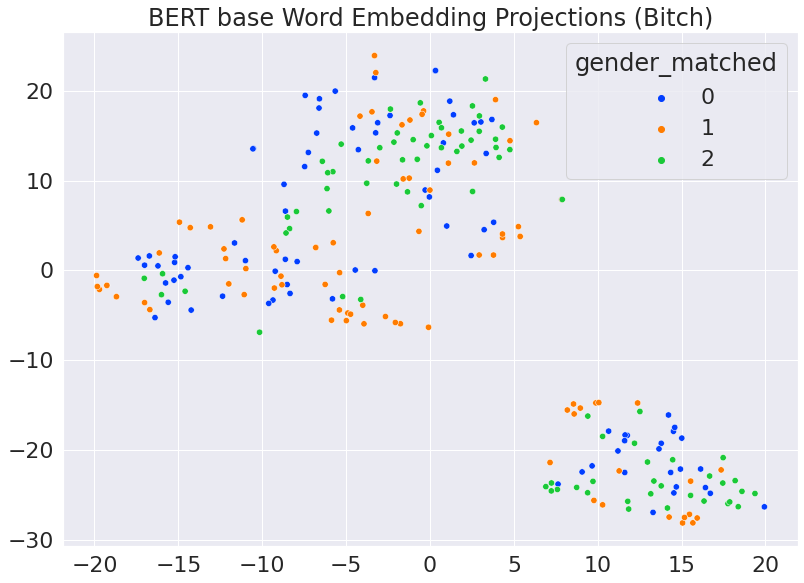

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsneB_[:, 0], tsneB_[:, 1], alpha =1, hue = bitch_sample.loc[~bitch_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("BERT base Word Embedding Projections (Bitch)")
plt.savefig("plot/b_word.png")

##Wh word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
whore_df = pd.read_csv("whore_df.csv")

In [ ]:
whore_df.gender_matched.value_counts()

0    237
1     24
2      2
Name: gender_matched, dtype: int64

In [ ]:
whore_df = whore_df.reset_index(drop=True)

In [ ]:
whore_df

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index,tokenized_text
0,Cemetry Gates - 2011 Remaster,The Smiths,A dreaded sunny day So I meet you at the cemet...,1986,52.0,False,False,False,False,False,True,Unknown,1980s,the smiths,0,"was ripped Some dizzy whore, 1804 A dreaded su...",47,"['[CLS]', 'was', 'ripped', 'some', 'dizzy', 'w..."
1,No More,Disturbed,Once again we hear them calling for war It doe...,2018,57.0,False,False,False,False,False,True,Unknown,2010s,disturbed,0,It's time to make them realize We will no long...,342,"['[CLS]', 'it', ""'"", 's', 'time', 'to', 'make'..."
2,No More,Disturbed,Once again we hear them calling for war It doe...,2018,57.0,False,False,False,False,False,True,Unknown,2010s,disturbed,0,It's time to make them realize We will no long...,342,"['[CLS]', 'it', ""'"", 's', 'time', 'to', 'make'..."
3,No More,Disturbed,Once again we hear them calling for war It doe...,2018,57.0,False,False,False,False,False,True,Unknown,2010s,disturbed,0,It's time to make them realize We will no long...,342,"['[CLS]', 'it', ""'"", 's', 'time', 'to', 'make'..."
4,No More,Disturbed,Once again we hear them calling for war It doe...,2018,57.0,False,False,False,False,False,True,Unknown,2010s,disturbed,0,It's time to make them realize We will no long...,342,"['[CLS]', 'it', ""'"", 's', 'time', 'to', 'make'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,There S Not A Problem My Squad Can T Fix,Busta Rhymes,C'mon yeah villain C'mon aight I got this side...,2006,NaN,False,False,False,False,True,False,Unknown,2000s,busta rhymes,0,fly whores and tours Fillin my pipe with no me...,35549,"['[CLS]', 'fly', 'whore', '##s', 'and', 'tours..."
259,Wife In Law,Busta Rhymes,Yeah yeah yeah yeah Yeah yeah yeah yeah Yeah y...,2006,NaN,False,False,False,False,True,False,Unknown,2000s,busta rhymes,0,my bitch for the triflin whore Type of bitch t...,35581,"['[CLS]', 'my', 'bitch', 'for', 'the', 'tri', ..."
260,Violators,Busta Rhymes,Let's get it started get it started Let's kee...,2006,NaN,False,False,False,False,True,False,Unknown,2000s,busta rhymes,0,you see a whore,35582,"['[CLS]', 'you', 'see', 'a', 'whore', '[SEP]']"
261,Sin Of The City,Duran Duran,Coat check girl up in Happyland Has a violent ...,1993,NaN,False,False,False,False,False,True,Unknown,1990s,duran duran,0,The city has more a hundred thousand wars All ...,36797,"['[CLS]', 'the', 'city', 'has', 'more', 'a', '..."


In [ ]:
sents = whore_df.segmented.values.tolist()

In [ ]:
len(sents)

263

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = embeddings.main(sent, whore_lst, layers = [-2]) #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_wh = torch.stack(emb_lst).numpy()
embs_wh.shape

(225, 768)

In [ ]:
len(na_lst)

38

In [ ]:
embs_wh=embs_wh.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_wh)
reduced= pca.transform(embs_wh)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


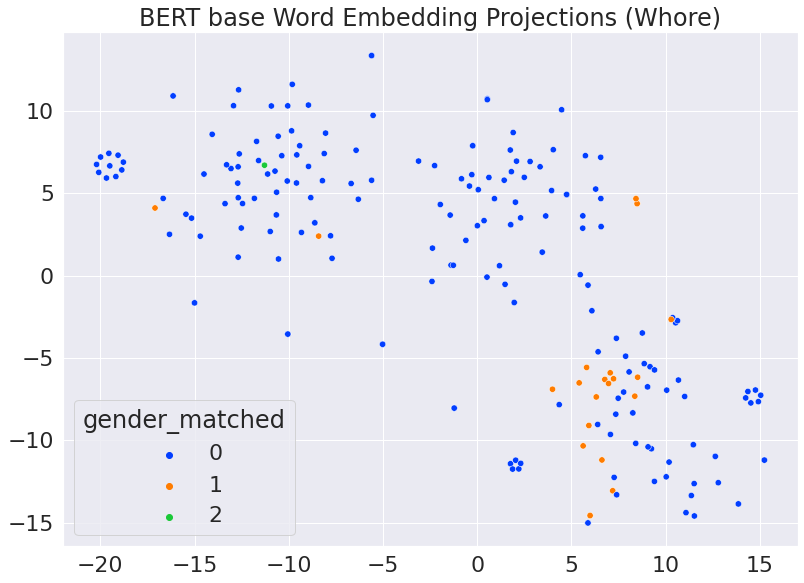

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = whore_df.loc[~whore_df.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("BERT base Word Embedding Projections (Whore)")
plt.savefig("plot/wh_word.png")

##F word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
fuck_df = pd.read_csv("fuck_df.csv")

In [ ]:
fuck_df.gender_matched.value_counts()

0    23061
1      874
2      193
Name: gender_matched, dtype: int64

In [ ]:
fuck_sample = fuck_df.groupby("gender_matched").sample(193, random_state=42).reset_index(drop=True)

In [ ]:
fuck_sample

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index,tokenized_text
0,Lemme Freak,Lil Dicky,"Drunk, faded Browned out, looking all shady Tw...",2015,63.0,False,False,False,False,True,False,Unknown,2010s,lil dicky,0,"then I don't work with these people,"" she star...",235,"[[CLS], then, i, don, ', t, work, with, these,..."
1,Freestyle,Dmx,Uh uh uh Niggaz gettin trampled on what's all ...,2006,NaN,False,False,False,False,True,False,Unknown,2000s,dmx,0,And then I snuff em out four to the mid fuck,16686,"[[CLS], and, then, i, s, ##nu, ##ff, em, out, ..."
2,Instagram - Bassjackers Remix,Dimitri Vegas & Like Mike,NA Just bought a black Ferrari House in the hi...,2019,21.0,True,False,False,False,False,False,Unknown,2010s,dimitri vegas like mike,0,I don't give a fuck about your Instagram Fly a...,1453,"[[CLS], i, don, ', t, give, a, fuck, about, yo..."
3,Tiimmy Turner,Desiigner,"Yeah, yeah, yeah, yeah Grrrrraaaah Yeah, yeah,...",2016,72.0,False,False,False,False,True,False,Unknown,2010s,desiigner,0,", she fuckin' for BET Wildin' for wallet",2984,"[[CLS], ,, she, fuck, ##in, ', for, bet, wild,..."
4,Burn Mf,Five Finger Death Punch,My heart is frozen My soul's been broken The w...,2013,NaN,False,False,False,False,False,False,Unknown,2010s,five finger death punch,0,mother fucker burn,27056,"[[CLS], mother, fuck, ##er, burn, [SEP]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,After Party,Adore Delano,It's 2 AM your fingertips are running down my ...,2016,NaN,False,False,True,False,False,False,Unknown,2010s,adore delano,2,and I'll fuck who I want,9695,"[[CLS], and, i, ', ll, fuck, who, i, want, [SEP]]"
575,The Way (feat. Chance the Rapper),Kehlani,You so damn important Everything you do shows ...,2015,66.0,False,False,False,True,False,False,Unknown,2010s,kehlani,2,"when we fuck, RE/MAXIt get hot than a mug",5335,"[[CLS], when, we, fuck, ,, re, /, maxi, ##t, g..."
576,Echelon,Angel Haze,I'm in that new school G5 wagon Color Komodo d...,2013,NaN,False,False,False,False,True,False,Unknown,2010s,angel haze,2,I'm on that fuck,9967,"[[CLS], i, ', m, on, that, fuck, [SEP]]"
577,The Way (feat. Chance the Rapper),Kehlani,You so damn important Everything you do shows ...,2015,66.0,False,False,False,True,False,False,Unknown,2010s,kehlani,2,"It's the way you love, the way you fuck, the w...",5335,"[[CLS], it, ', s, the, way, you, love, ,, the,..."


In [ ]:
sents = fuck_sample.segmented.values.tolist()

In [ ]:
len(sents)

579

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = embeddings.main(sent, fuck_lst, layers = [-2]) #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

### Visualize Embeddings

In [ ]:
embs_f = torch.stack(emb_lst).numpy()
embs_f.shape

(549, 768)

In [ ]:
len(na_lst)

30

In [ ]:
embs_f=embs_f.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_f)
reduced= pca.transform(embs_f)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


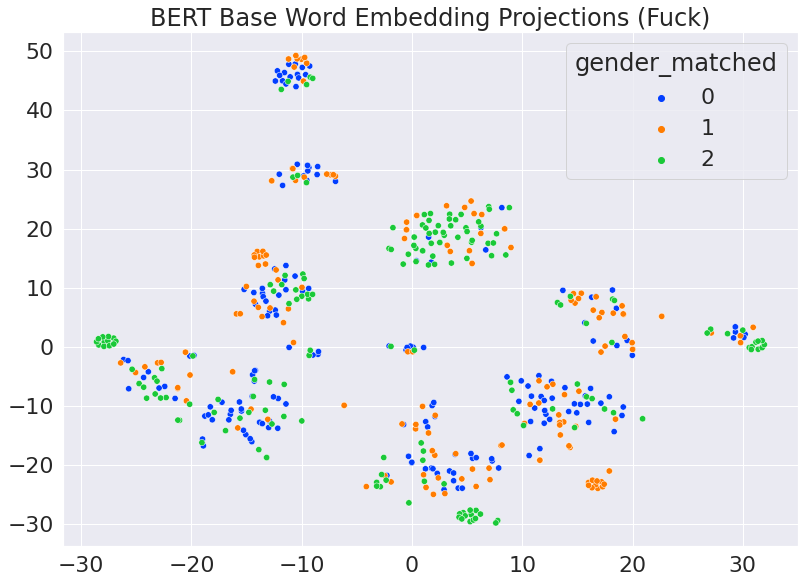

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = fuck_sample.loc[~fuck_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("BERT Base Word Embedding Projections (Fuck)")
plt.savefig("f_word.png")

##Sh word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
shit_df = pd.read_csv("shit_df.csv")

In [ ]:
shit_df.gender_matched.value_counts()

0    17576
1      816
2      111
Name: gender_matched, dtype: int64

In [ ]:
shit_sample = shit_df.groupby("gender_matched").sample(111, random_state=42).reset_index(drop=True)

In [ ]:
shit_sample

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index,tokenized_text
0,Music,Fat Joe,Coca Krillz mania BX T S til I die muh'fucker...,2009,NaN,False,False,False,False,True,False,Unknown,2000s,fat joe,0,I don't do shit Bein,13173,"['[CLS]', 'i', 'don', ""'"", 't', 'do', 'shit', ..."
1,Things We Be Doin For Money Part 2,Busta Rhymes,Huh yeah fuck that Niggas is gon have to get i...,2008,NaN,False,False,False,False,True,False,Unknown,2000s,busta rhymes,0,bullshit,35618,"['[CLS]', 'bullshit', '[SEP]']"
2,Pandemonium (feat. Wale & Rick Ross),Meek Mill,"Three passports, three first class Tickets to ...",2011,32.0,False,False,False,False,True,False,Unknown,2010s,meek mill,0,"That's game bitch ain't shit, nudies and some ...",3064,"['[CLS]', 'that', ""'"", 's', 'game', 'bitch', '..."
3,Isis,Joyner Lucas,"Attention Deficit Hyperactivity Disorder, or b...",2019,78.0,False,False,False,False,True,False,Unknown,2010s,joyner lucas,0,I've come to body this shit,2592,"['[CLS]', 'i', ""'"", 've', 'come', 'to', 'body'..."
4,BURIED,27CLUB,Feeling like I'm buried alive Got me thinking ...,2019,46.0,False,False,False,False,True,False,Unknown,2010s,27club,0,Hey You on some fake shit Never thought that y...,1363,"['[CLS]', 'hey', 'you', 'on', 'some', 'fake', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,Drunk In Love,Angel Haze,I've been thinking I've been thinking Ya if I ...,2014,NaN,False,False,False,False,True,False,Unknown,2010s,angel haze,2,shit go down,9994,"['[CLS]', 'shit', 'go', 'down', '[SEP]']"
329,Echelon,Angel Haze,I'm in that new school G5 wagon Color Komodo d...,2013,NaN,False,False,False,False,True,False,Unknown,2010s,angel haze,2,all the latest Killing these motherfuckers And...,9967,"['[CLS]', 'all', 'the', 'latest', 'killing', '..."
330,Impossible,Angel Haze,There is no part of me left in my brain I am ...,2015,NaN,False,False,False,False,True,False,Unknown,2010s,angel haze,2,this shit's a problem man I just go through my...,9988,"['[CLS]', 'this', 'shit', ""'"", 's', 'a', 'prob..."
331,Live It Up Practice,Angel Haze,Verse1 Heart Broken too often love wasted no p...,2012,NaN,False,False,False,False,True,False,Unknown,2010s,angel haze,2,but im going cant feel shit thats boring thats...,9980,"['[CLS]', 'but', 'im', 'going', 'can', '##t', ..."


In [ ]:
sents = shit_sample.segmented.values.tolist()

In [ ]:
len(sents)

333

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = embeddings.main(sent, shit_lst, layers = [-2]) #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_sh = torch.stack(emb_lst).numpy()
embs_sh.shape

(307, 768)

In [ ]:
len(na_lst)

26

In [ ]:
embs_sh=embs_sh.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_sh)
reduced= pca.transform(embs_sh)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


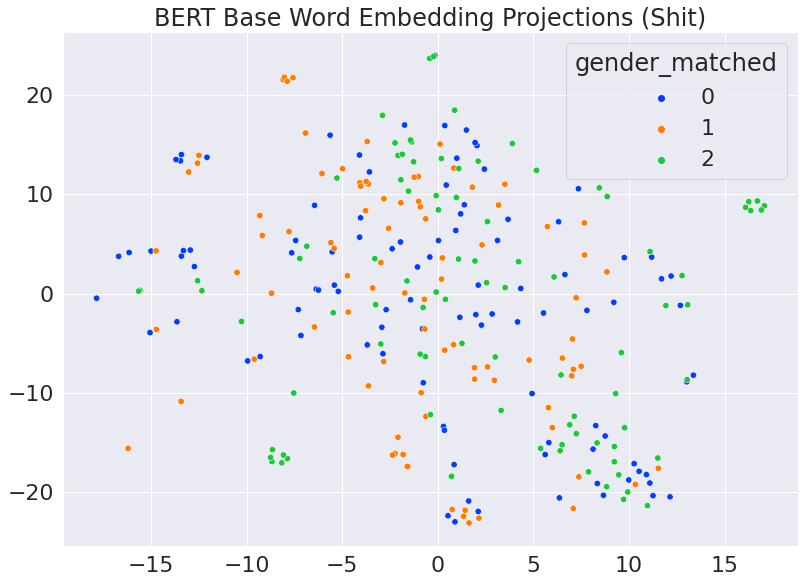

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = shit_sample.loc[~shit_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("BERT Base Word Embedding Projections (Shit)")
plt.savefig("sh_word.png")

# Extract Embeddings

In [ ]:
from sklearn import *
import seaborn as sns

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [ ]:
!unzip /content/lyrics_bert/mlm_bert_base.zip -d lyrics-bert 

Archive:  /content/lyrics_bert/mlm_bert_base.zip
replace lyrics-bert/__MACOSX/._mlm_bert_base? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lyrics-bert/__MACOSX/._mlm_bert_base  
replace lyrics-bert/mlm_bert_base/config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lyrics-bert/mlm_bert_base/config.json  
replace lyrics-bert/mlm_bert_base/pytorch_model.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lyrics-bert/mlm_bert_base/pytorch_model.bin  y
y



## All Slurs

In [ ]:
whore_lst = [w for w in bad_wrds if "whore" in w]
fuck_lst = [w for w in bad_wrds if "fuck" in w]
shit_lst = [w for w in bad_wrds if "shit" in w]
sissy_lst = [w for w in bad_wrds if "sissy" in w]
slut_lst = [w for w in bad_wrds if "slut" in w]
hoe_lst = [w for w in bad_wrds if "hoe" in w]
hoe_lst.append("hoe")
bitch_lst = [w for w in bad_wrds if "bitch" in w]
shorty_lst = [w for w in bad_wrds if "shorty" in w or "shawty" in w]
shorty_lst.append("shorty")
shorty_lst.append("shawty")
#skeezer_lst = ["skeezer"]

In [ ]:
lsts = [bitch_lst, whore_lst, hoe_lst, fuck_lst, shit_lst, sissy_lst, slut_lst, shorty_lst]

In [ ]:
slurs_df = df.tokenized_text.apply(lambda x: embeddings.find_words(x, lsts))

In [ ]:
bitch_df = df[slurs_df.apply(lambda x: x[0])]
whore_df = df[slurs_df.apply(lambda x: x[1])]
hoe_df = df[slurs_df.apply(lambda x: x[2])]
fuck_df = df[slurs_df.apply(lambda x: x[3])]
shit_df = df[slurs_df.apply(lambda x: x[4])]
sissy_df = df[slurs_df.apply(lambda x: x[5])]
slut_df = df[slurs_df.apply(lambda x: x[6])]
shorty_df = df[slurs_df.apply(lambda x: x[7])]

In [ ]:
print(f"{len(bitch_df)} sentences contain word related to bitch")
print(f"{len(whore_df)} sentences contain word related to whore")
print(f"{len(hoe_df)} sentences contain word related to hoe")
print(f"{len(sissy_df)} sentences contain word related to sissy")
print(f"{len(slut_df)} sentences contain word related to slut")
print(f"{len(shorty_df)} sentences contain word related to shorty")
print(f"{len()} sentences contain word related to fuck")
print(f"{len(shit_df)} sentences contain word related to shit")

17329 sentences contain word related to bitch
263 sentences contain word related to whore
0 sentences contain word related to hoe
0 sentences contain word related to sissy
0 sentences contain word related to slut
0 sentences contain word related to shorty
24128 sentences contain word related to fuck
18503 sentences contain word related to shit


In [ ]:
bitch_df.to_csv("bitch.csv", index = False)
whore_df.to_csv("whore_df.csv", index = False)
fuck_df.to_csv("fuck_df.csv", index = False)
shit_df.to_csv("shit_df.csv", index = False)

##B word

In [ ]:
bitch_df = pd.read_csv("bitch.csv")
bitch_df = bitch_df.reset_index(drop = True)

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
bitch_df.gender_matched.value_counts()

0    16199
1      917
2      213
Name: gender_matched, dtype: int64

In [ ]:
bitch_sample = bitch_df.groupby("gender_matched").sample(100, random_state=7).reset_index(drop=True)

In [ ]:
bitch_sample.head()

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index,tokenized_text
0,Bang Bang,YNW Melly,"Ayy, look Know what I'm sayin', I'm straight o...",2019,78.0,False,False,False,False,True,False,Unknown,2010s,ynw melly,0,", uh I'm tryna get it in, these bitches snorti...",4953,"[[CLS], ,, uh, i, ', m, try, ##na, get, it, in..."
1,Dance Move,French Montana,Bust a dance move Pop a bottle pop a tag and b...,2012,NaN,False,False,False,False,True,False,Unknown,2010s,french montana,0,Shorty want this money tell that bitch to bust...,14390,"[[CLS], short, ##y, want, this, money, tell, t..."
2,KIKA,6ix9ine,"Bitch, we in the city on that hot shit Lookin'...",2018,18.0,False,False,False,False,True,False,Unknown,2010s,6ix9ine,0,"John Cena shit, I can't see the bitch In the D...",5171,"[[CLS], john, ce, ##na, shit, ,, i, can, ', t,..."
3,The Real Slim Shady,Eminem,"May I have your attention, please? May I have ...",2005,10.0,False,False,False,False,True,False,Unknown,2000s,eminem,0,So I can sit next to Carson Daly and Fred Durs...,1344,"[[CLS], so, i, can, sit, next, to, carson, dal..."
4,Pandemonium (feat. Wale & Rick Ross),Meek Mill,"Three passports, three first class Tickets to ...",2011,32.0,False,False,False,False,True,False,Unknown,2010s,meek mill,0,Three's for the bitches that be fucking for th...,3064,"[[CLS], three, ', s, for, the, bitch, ##es, th..."


In [ ]:
sents = bitch_sample.segmented.values.tolist()

In [ ]:
len(sents)

300

In [ ]:
emb_lst_b = []
na_lst = []
for i, sent in enumerate(sents):
    emb = embeddings.main(sent, bitch_lst, layers = [-2], model = "/content/lyrics-bert") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst_b.append(emb)

### Visualize Embeddings

In [ ]:
len(emb_lst_b)

266

In [ ]:
len(na_lst)

34

In [ ]:
embs_B = torch.stack(emb_lst_b).numpy()
embs_B.shape

(266, 768)

In [ ]:
embs_B=embs_B.astype(np.float64)

In [ ]:
pcaB_= decomposition.PCA(n_components = 44).fit(embs_B)
reducedB_ = pcaB_.transform(embs_B)
tsneB_ = manifold.TSNE(n_components = 2).fit_transform(reducedB_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
bitch_sample.loc[~bitch_sample.index.isin(na_lst)].gender_matched

0      0
1      0
2      0
3      0
4      0
      ..
292    2
293    2
295    2
296    2
299    2
Name: gender_matched, Length: 266, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


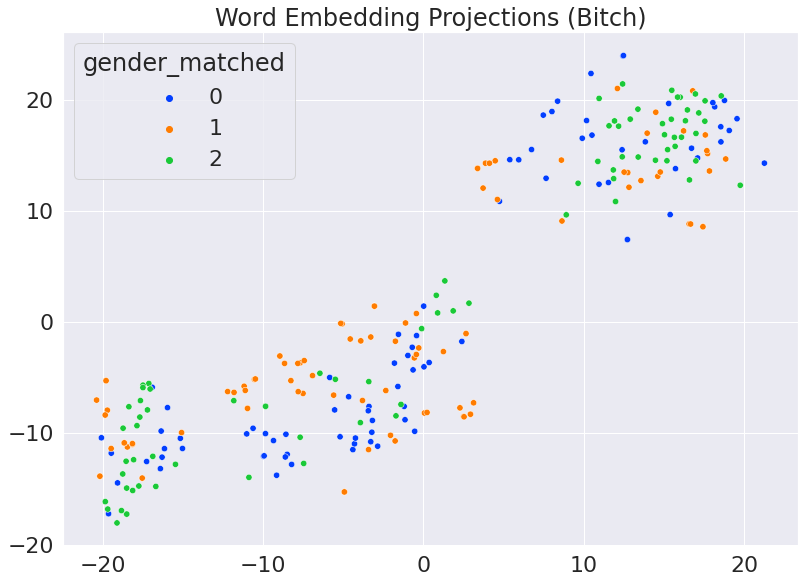

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsneB_[:, 0], tsneB_[:, 1], alpha =1, hue = bitch_sample.loc[~bitch_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("Word Embedding Projections (Bitch)")
plt.savefig("plot/b_word.png")

##Wh word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
whore_df = pd.read_csv("whore_df.csv")

In [ ]:
whore_df.gender_matched.value_counts()

0    237
1     24
2      2
Name: gender_matched, dtype: int64

In [ ]:
whore_df = whore_df.reset_index(drop=True)

In [ ]:
whore_df

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index,tokenized_text
0,Cemetry Gates - 2011 Remaster,The Smiths,A dreaded sunny day So I meet you at the cemet...,1986,52.0,False,False,False,False,False,True,Unknown,1980s,the smiths,0,"was ripped Some dizzy whore, 1804 A dreaded su...",47,"[[CLS], was, ripped, some, dizzy, whore, ,, 18..."
1,No More,Disturbed,Once again we hear them calling for war It doe...,2018,57.0,False,False,False,False,False,True,Unknown,2010s,disturbed,0,It's time to make them realize We will no long...,342,"[[CLS], it, ', s, time, to, make, them, realiz..."
2,No More,Disturbed,Once again we hear them calling for war It doe...,2018,57.0,False,False,False,False,False,True,Unknown,2010s,disturbed,0,It's time to make them realize We will no long...,342,"[[CLS], it, ', s, time, to, make, them, realiz..."
3,No More,Disturbed,Once again we hear them calling for war It doe...,2018,57.0,False,False,False,False,False,True,Unknown,2010s,disturbed,0,It's time to make them realize We will no long...,342,"[[CLS], it, ', s, time, to, make, them, realiz..."
4,No More,Disturbed,Once again we hear them calling for war It doe...,2018,57.0,False,False,False,False,False,True,Unknown,2010s,disturbed,0,It's time to make them realize We will no long...,342,"[[CLS], it, ', s, time, to, make, them, realiz..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,There S Not A Problem My Squad Can T Fix,Busta Rhymes,C'mon yeah villain C'mon aight I got this side...,2006,NaN,False,False,False,False,True,False,Unknown,2000s,busta rhymes,0,fly whores and tours Fillin my pipe with no me...,35549,"[[CLS], fly, whore, ##s, and, tours, fill, ##i..."
259,Wife In Law,Busta Rhymes,Yeah yeah yeah yeah Yeah yeah yeah yeah Yeah y...,2006,NaN,False,False,False,False,True,False,Unknown,2000s,busta rhymes,0,my bitch for the triflin whore Type of bitch t...,35581,"[[CLS], my, bitch, for, the, tri, ##fl, ##in, ..."
260,Violators,Busta Rhymes,Let's get it started get it started Let's kee...,2006,NaN,False,False,False,False,True,False,Unknown,2000s,busta rhymes,0,you see a whore,35582,"[[CLS], you, see, a, whore, [SEP]]"
261,Sin Of The City,Duran Duran,Coat check girl up in Happyland Has a violent ...,1993,NaN,False,False,False,False,False,True,Unknown,1990s,duran duran,0,The city has more a hundred thousand wars All ...,36797,"[[CLS], the, city, has, more, a, hundred, thou..."


In [ ]:
sents = whore_df.segmented.values.tolist()

In [ ]:
len(sents)

263

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = embeddings.main(sent, whore_lst, layers = [-2], model = "/content/lyrics-bert") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_wh = torch.stack(emb_lst).numpy()
embs_wh.shape

(225, 768)

In [ ]:
len(na_lst)

38

In [ ]:
embs_wh=embs_wh.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_wh)
reduced= pca.transform(embs_wh)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


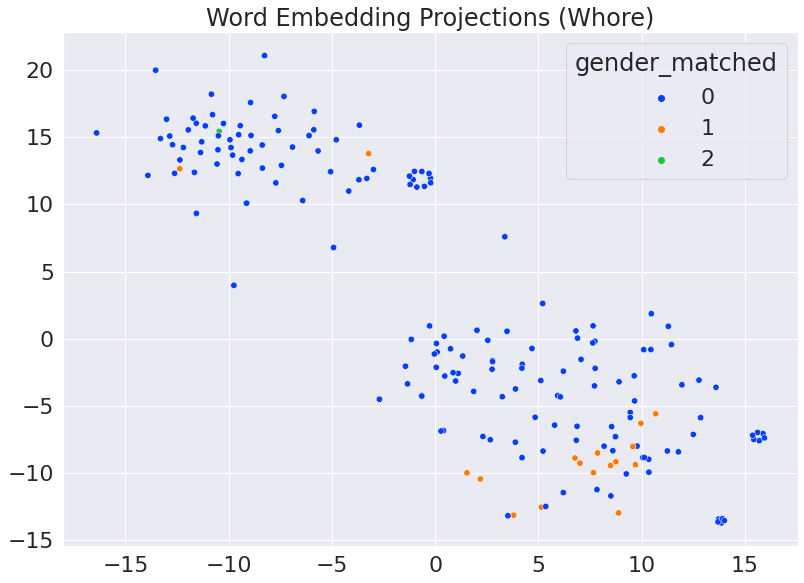

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = whore_df.loc[~whore_df.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("Word Embedding Projections (Whore)")
plt.savefig("plot/wh_word.png")

##F word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
fuck_df = pd.read_csv("fuck_df.csv")

In [ ]:
fuck_df.gender_matched.value_counts()

0    23061
1      874
2      193
Name: gender_matched, dtype: int64

In [ ]:
fuck_sample = fuck_df.groupby("gender_matched").sample(193, random_state=42).reset_index(drop=True)

In [ ]:
fuck_sample

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index,tokenized_text
0,Lemme Freak,Lil Dicky,"Drunk, faded Browned out, looking all shady Tw...",2015,63.0,False,False,False,False,True,False,Unknown,2010s,lil dicky,0,"then I don't work with these people,"" she star...",235,"[[CLS], then, i, don, ', t, work, with, these,..."
1,Freestyle,Dmx,Uh uh uh Niggaz gettin trampled on what's all ...,2006,NaN,False,False,False,False,True,False,Unknown,2000s,dmx,0,And then I snuff em out four to the mid fuck,16686,"[[CLS], and, then, i, s, ##nu, ##ff, em, out, ..."
2,Instagram - Bassjackers Remix,Dimitri Vegas & Like Mike,NA Just bought a black Ferrari House in the hi...,2019,21.0,True,False,False,False,False,False,Unknown,2010s,dimitri vegas like mike,0,I don't give a fuck about your Instagram Fly a...,1453,"[[CLS], i, don, ', t, give, a, fuck, about, yo..."
3,Tiimmy Turner,Desiigner,"Yeah, yeah, yeah, yeah Grrrrraaaah Yeah, yeah,...",2016,72.0,False,False,False,False,True,False,Unknown,2010s,desiigner,0,", she fuckin' for BET Wildin' for wallet",2984,"[[CLS], ,, she, fuck, ##in, ', for, bet, wild,..."
4,Burn Mf,Five Finger Death Punch,My heart is frozen My soul's been broken The w...,2013,NaN,False,False,False,False,False,False,Unknown,2010s,five finger death punch,0,mother fucker burn,27056,"[[CLS], mother, fuck, ##er, burn, [SEP]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,After Party,Adore Delano,It's 2 AM your fingertips are running down my ...,2016,NaN,False,False,True,False,False,False,Unknown,2010s,adore delano,2,and I'll fuck who I want,9695,"[[CLS], and, i, ', ll, fuck, who, i, want, [SEP]]"
575,The Way (feat. Chance the Rapper),Kehlani,You so damn important Everything you do shows ...,2015,66.0,False,False,False,True,False,False,Unknown,2010s,kehlani,2,"when we fuck, RE/MAXIt get hot than a mug",5335,"[[CLS], when, we, fuck, ,, re, /, maxi, ##t, g..."
576,Echelon,Angel Haze,I'm in that new school G5 wagon Color Komodo d...,2013,NaN,False,False,False,False,True,False,Unknown,2010s,angel haze,2,I'm on that fuck,9967,"[[CLS], i, ', m, on, that, fuck, [SEP]]"
577,The Way (feat. Chance the Rapper),Kehlani,You so damn important Everything you do shows ...,2015,66.0,False,False,False,True,False,False,Unknown,2010s,kehlani,2,"It's the way you love, the way you fuck, the w...",5335,"[[CLS], it, ', s, the, way, you, love, ,, the,..."


In [ ]:
sents = fuck_sample.segmented.values.tolist()

In [ ]:
len(sents)

579

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = embeddings.main(sent, fuck_lst, layers = [-2], model = "/content/lyrics-bert") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_f = torch.stack(emb_lst).numpy()
embs_f.shape

(549, 768)

In [ ]:
len(na_lst)

30

In [ ]:
embs_f=embs_f.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_f)
reduced= pca.transform(embs_f)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


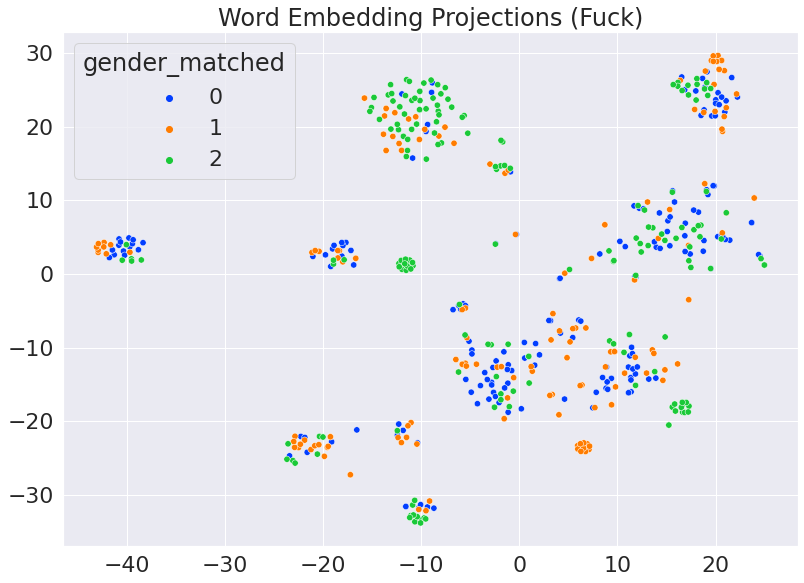

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = fuck_sample.loc[~fuck_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("Word Embedding Projections (Fuck)")
plt.savefig("plot/f_word.png")

##Sh word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
shit_df = pd.read_csv("shit_df.csv")

In [ ]:
shit_df.gender_matched.value_counts()

0    17576
1      816
2      111
Name: gender_matched, dtype: int64

In [ ]:
shit_sample = shit_df.groupby("gender_matched").sample(111, random_state=42).reset_index(drop=True)

In [ ]:
shit_sample

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index,tokenized_text
0,Music,Fat Joe,Coca Krillz mania BX T S til I die muh'fucker...,2009,NaN,False,False,False,False,True,False,Unknown,2000s,fat joe,0,I don't do shit Bein,13173,"['[CLS]', 'i', 'don', ""'"", 't', 'do', 'shit', ..."
1,Things We Be Doin For Money Part 2,Busta Rhymes,Huh yeah fuck that Niggas is gon have to get i...,2008,NaN,False,False,False,False,True,False,Unknown,2000s,busta rhymes,0,bullshit,35618,"['[CLS]', 'bullshit', '[SEP]']"
2,Pandemonium (feat. Wale & Rick Ross),Meek Mill,"Three passports, three first class Tickets to ...",2011,32.0,False,False,False,False,True,False,Unknown,2010s,meek mill,0,"That's game bitch ain't shit, nudies and some ...",3064,"['[CLS]', 'that', ""'"", 's', 'game', 'bitch', '..."
3,Isis,Joyner Lucas,"Attention Deficit Hyperactivity Disorder, or b...",2019,78.0,False,False,False,False,True,False,Unknown,2010s,joyner lucas,0,I've come to body this shit,2592,"['[CLS]', 'i', ""'"", 've', 'come', 'to', 'body'..."
4,BURIED,27CLUB,Feeling like I'm buried alive Got me thinking ...,2019,46.0,False,False,False,False,True,False,Unknown,2010s,27club,0,Hey You on some fake shit Never thought that y...,1363,"['[CLS]', 'hey', 'you', 'on', 'some', 'fake', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,Drunk In Love,Angel Haze,I've been thinking I've been thinking Ya if I ...,2014,NaN,False,False,False,False,True,False,Unknown,2010s,angel haze,2,shit go down,9994,"['[CLS]', 'shit', 'go', 'down', '[SEP]']"
329,Echelon,Angel Haze,I'm in that new school G5 wagon Color Komodo d...,2013,NaN,False,False,False,False,True,False,Unknown,2010s,angel haze,2,all the latest Killing these motherfuckers And...,9967,"['[CLS]', 'all', 'the', 'latest', 'killing', '..."
330,Impossible,Angel Haze,There is no part of me left in my brain I am ...,2015,NaN,False,False,False,False,True,False,Unknown,2010s,angel haze,2,this shit's a problem man I just go through my...,9988,"['[CLS]', 'this', 'shit', ""'"", 's', 'a', 'prob..."
331,Live It Up Practice,Angel Haze,Verse1 Heart Broken too often love wasted no p...,2012,NaN,False,False,False,False,True,False,Unknown,2010s,angel haze,2,but im going cant feel shit thats boring thats...,9980,"['[CLS]', 'but', 'im', 'going', 'can', '##t', ..."


In [ ]:
sents = shit_sample.segmented.values.tolist()

In [ ]:
len(sents)

333

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = embeddings.main(sent, shit_lst, layers = [-2], model = "/content/lyrics-bert") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_sh = torch.stack(emb_lst).numpy()
embs_sh.shape

(307, 768)

In [ ]:
len(na_lst)

26

In [ ]:
embs_sh=embs_sh.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_sh)
reduced= pca.transform(embs_sh)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


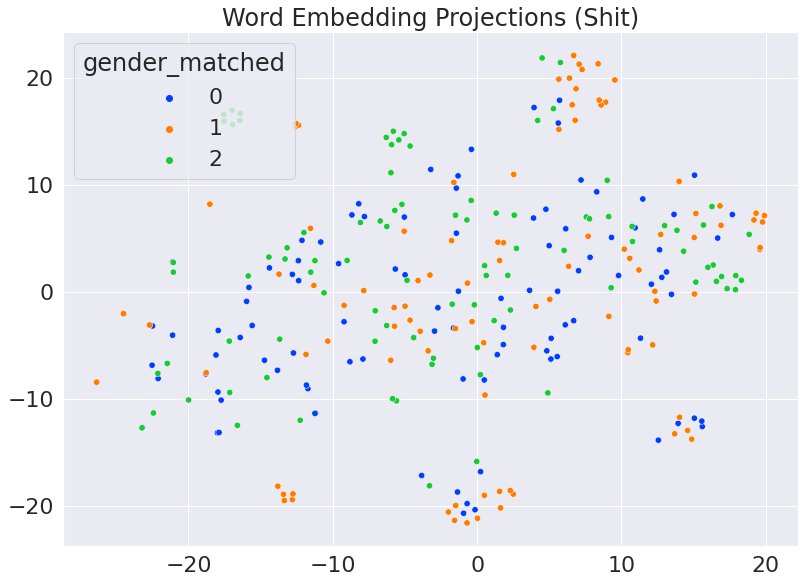

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = shit_sample.loc[~shit_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("Word Embedding Projections (Shit)")
plt.savefig("plot/sh_word.png")